<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220816_RandomForest_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 랜덤 포레스트
 - 결정 트리의 단점인 오버피팅 문제를 완화
 - 랜덤으로 생성된 많은 트리를 이용한 앙상블 기법
 - 앙상블 기법을 사용한 트리 기반 모델 중 가장 보편적
 - 부스팅 모델에 비하면 예측력/속도에서 떨어짐

# 중고차 판매 이력 데이터셋을 이용해 중고차 가격 예측
 - 알고리즘 : 랜덤 포레스트
 - 문제유형 : 회귀
 - 평가지표 : RMSE
 - 사용모델 : RandomForestRegressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'http://media.githubusercontent.com/media/musthave-ML10/data_source/main/car.csv'
data = pd.read_csv(file_url)

In [2]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


 - 결측치가 있는 변수들이 있음
 - engine 변수는 숫자형 데이터여야 하는데 'cc'가 뒤에 붙어 문자형 데이터로 인식됨
 

In [4]:
round(data.describe(), 2)

,year,selling_price,km_driven,seats
count,8128.00,8128.00,8128.00,7907.00
mean,2013.80,638271.81,69819.51,5.42
std,4.04,806253.40,56550.55,0.96
min,1983.00,29999.00,1.00,2.00
25%,2011.00,254999.00,35000.00,5.00
50%,2015.00,450000.00,60000.00,5.00
75%,2017.00,675000.00,98000.00,5.00
max,2020.00,10000000.00,2360457.00,14.00


 - seling_price에서 max값이 유독 높음 → 아웃라이어
 - km_driven은 min, max 모두 아웃라이어
 - 선형 모델과 달리 트리모델은 아웃라이어에 대한 별도 처리가 필요하지 않다

## 전처리 : 텍스트 데이터
 - 문자형 데이터를 분리 : 판다스 시리즈에서 제공하는 str.split() 함수

In [5]:
data['engine']

0       1248 CC
1       1498 CC
2       1497 CC
3       1396 CC
4       1298 CC
         ...   
8123    1197 CC
8124    1493 CC
8125    1248 CC
8126    1396 CC
8127    1396 CC
Name: engine, Length: 8128, dtype: object

In [6]:
data['engine'].str.split() # 판다스의 시리즈에서 사용가능한 str.split() 

0       [1248, CC]
1       [1498, CC]
2       [1497, CC]
3       [1396, CC]
4       [1298, CC]
           ...    
8123    [1197, CC]
8124    [1493, CC]
8125    [1248, CC]
8126    [1396, CC]
8127    [1396, CC]
Name: engine, Length: 8128, dtype: object

In [7]:
data['engine'].str.split(expand=True) # expand=True : 분리한 문자열을 별도의 컬럼에 배치(DataFrame형태)

,0,1
0,1248,CC
1,1498,CC
2,1497,CC
3,1396,CC
4,1298,CC
...,...,...
8123,1197,CC
8124,1493,CC
8125,1248,CC
8126,1396,CC


In [8]:
data[['engine','engine_unit']] = data['engine'].str.split(expand=True) # 분할된 문자들을 새로운 변수들로 저장

In [9]:
data['engine'].head()

0    1248
1    1498
2    1497
3    1396
4    1298
Name: engine, dtype: object

 - 단위는 별도의 변수로 할당했으나, object타입(문자형)이므로 숫자형 데이터로 변환 : astype()

In [10]:
data['engine'] = data['engine'].astype('float32')

In [11]:
data['engine'].head()

0    1248.0
1    1498.0
2    1497.0
3    1396.0
4    1298.0
Name: engine, dtype: float32

In [12]:
data.drop('engine_unit', axis=1, inplace=True) # 단위 변수 제거

### max_power 변수 전처리

In [13]:
data[['max_power', 'max_power_unit']] = data['max_power'].str.split(expand=True)

In [14]:
# data['max_power'] = data['max_power'].astype('float32')
# ValueError: could not convert string to float: 'bhp' → float32로 변경할 수 없는 'bhp'라는 값이 있다

In [15]:
data[data['max_power'] == 'bhp']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_power_unit
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796.0,bhp,NaN,8.0,None


 - 데이터에 숫자없이 bhp만 있어서 str.split()에서 빈칸을 기준으로 분리할 때 분리되지 않은채로 남음
 - 단 한건의 데이터이기 때문에 간단히 Nan 처리할 수 있지만, 여러건일 경우를 대비해 Try and Except 적용

In [16]:
def isFloat(value):
    try:                    # 시도
        num = float(value)
        return num
    except ValueError:      # 시도 중 에러가 난 경우
        return np.NaN       

In [17]:
# data['max_power'].apply(lambda x: np.NaN if (x=='bhp') else float(x))
data['max_power'] = data['max_power'].apply(isFloat) # apply(함수명)

In [18]:
data.drop('max_power_unit',axis=1, inplace=True)

### mileage 변수 전처리

In [19]:
data[['mileage', 'mileage_unit']]=data['mileage'].str.split(expand=True)

In [20]:
data['mileage'] = data['mileage'].astype('float32')

In [21]:
data['mileage_unit'].unique() # 두가지 단위가 있었네

array(['kmpl', 'km/kg', nan], dtype=object)

In [22]:
data['fuel'].unique() # 연료마다 연비를 나타내는 방식이 다름

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

 - 다른 종류의 연료로 주행거리를 비교하려면 →같은 기준을 세워야 한다
 - 1달러당 주행거리로 하자

  > Petrol : 리터당 $80.43

  > Diesel : 리터당 $73.56

  > LPG : 킬로그램당 $40.85

  > CNG : 킬로그램당 $44.23

In [23]:
def mile(x): # 입력값 x는 data전체
    if x['fuel'] == 'Petrol':
        return x['mileage'] / 80.43
    elif x['fuel'] == 'Diesel':
        return x['mileage'] / 73.56
    elif x['fuel'] == 'LPG':
        return x['mileage'] / 40.85
    else:
        return x['mileage'] / 44.23

In [24]:
data['mileage'] = data.apply(mile, axis=1) # DataFrame.appy(함수명, axis=1)
# Series.apply(함수명)

In [25]:
data.drop('mileage_unit', axis=1, inplace=True)

### torque 변수 전처리

In [26]:
data['torque'].head()

0              190Nm@ 2000rpm
1         250Nm@ 1500-2500rpm
2       12.7@ 2,700(kgm@ rpm)
3    22.4 kgm at 1750-2750rpm
4       11.5@ 4,500(kgm@ rpm)
Name: torque, dtype: object

 - Nm, nm, Kgm, kgm 섞여 있으므로 전체를 대문자화 해서 Nm, kgm으로 변경하여 별도 변수화

In [27]:
data['torque'] = data['torque'].str.upper()

In [28]:
def torque_unit(x):
    if 'NM' in str(x):
        return 'Nm'
    elif 'KGM' in str(x):
        return 'kgm'

In [29]:
data['torque_unit'] = data['torque'].apply(torque_unit)

In [30]:
data['torque_unit'].unique() # 데이터가 없어서 None 인지 확인 필요

array(['Nm', 'kgm', None], dtype=object)

In [31]:
data[data['torque_unit'].isna()]['torque'].unique()

array([nan, '250@ 1250-5000RPM', '510@ 1600-2400', '110(11.2)@ 4800',
       '210 / 1900'], dtype=object)

 - Nm, kgm도 없는 데이터와, NAN으로 입력된 값이 있음
 - 단위를 보아 Nm에 가까우므로 빈값과 함께 모두 단위는 Nm으로 설정

In [32]:
data['torque_unit'].fillna('Nm', inplace=True)

In [33]:
data['torque']

0                  190NM@ 2000RPM
1             250NM@ 1500-2500RPM
2           12.7@ 2,700(KGM@ RPM)
3        22.4 KGM AT 1750-2750RPM
4           11.5@ 4,500(KGM@ RPM)
                  ...            
8123             113.7NM@ 4000RPM
8124    24@ 1,900-2,750(KGM@ RPM)
8125               190NM@ 2000RPM
8126          140NM@ 1800-3000RPM
8127          140NM@ 1800-3000RPM
Name: torque, Length: 8128, dtype: object

 - 앞의 숫자까지만 인덱싱하여 분리 하고 싶음

In [34]:
string_example = '250NM@ 1500-2500RPM'
for i, j in enumerate(string_example):
    if j not in '0123456789.':  # j가 숫자가아니라면
        cut = i
        break

In [35]:
# 문자열내에서 숫자까지만 인덱싱하는 함수
def split_num(x):
    x = str(x) # 일단 문자형태로 바꿔서 iterable하게 만든다
    for i, j in enumerate(x):
        if j not in '0123456789.':
            cut = i
            break
    return x[:cut] # cut 인덱스까지 인덱싱하여 리턴

In [36]:
data['torque']

0                  190NM@ 2000RPM
1             250NM@ 1500-2500RPM
2           12.7@ 2,700(KGM@ RPM)
3        22.4 KGM AT 1750-2750RPM
4           11.5@ 4,500(KGM@ RPM)
                  ...            
8123             113.7NM@ 4000RPM
8124    24@ 1,900-2,750(KGM@ RPM)
8125               190NM@ 2000RPM
8126          140NM@ 1800-3000RPM
8127          140NM@ 1800-3000RPM
Name: torque, Length: 8128, dtype: object

In [37]:
data['torque'] = data['torque'].apply(split_num)

In [38]:
data['torque']

0         190
1         250
2        12.7
3        22.4
4        11.5
        ...  
8123    113.7
8124       24
8125      190
8126      140
8127      140
Name: torque, Length: 8128, dtype: object

In [39]:
# data['torque'] = data['torque'].astype('float64')
# ValueError: could not convert string to float: 

In [40]:
(data['torque']=='').sum() # ''공백을 갖는 데이터 개수 222개

222

In [41]:
# try except 형식은 lambda 함수로 만들수 없음
def isFloat(value):
    try:
        return float(value)
    except ValueError:
        return np.NaN

In [42]:
data['torque'] = data['torque'].apply(isFloat)
# data['torque'].replace('', np.NaN)

 - 단위에 따른 차이를 맞춰주는 변환
 - Nm과 kgm은 중력과 관련 : kgm X 9.8066 = Nm

  > kgm이면 9.8066을 곱하여 → Nm반환
  
  > Nm이면 그대로 → Nm반환

 - 함수 내에 두 변수가 사용되기 때문에 입력은 데이터 프레임 전체를 받는 x로 전제하고 만든다

In [43]:
# DataFrame 전체를 파라미터로 받는 함수 : apply(함수명, axis=1)
def torque_trans(x):
    if x['torque_unit'] == 'kgm':
        return x['torque'] * 9.8066
    else:
        return x['torque']

In [44]:
data['torque'] = data.apply(torque_trans, axis=1)

In [45]:
data.drop('torque_unit', axis=1, inplace=True)

In [46]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,0.318108,1248.0,74.00,190.00000,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,0.287384,1498.0,103.52,250.00000,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,0.220067,1497.0,78.00,124.54382,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,0.312670,1396.0,90.00,219.66784,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,0.200174,1298.0,88.20,112.77590,5.0


### name 변수 처리하기

In [47]:
data['name'].value_counts()

Maruti Swift Dzire VDI                             129
Maruti Alto 800 LXI                                 82
Maruti Alto LXi                                     71
BMW X4 M Sport X xDrive20d                          62
Maruti Swift VDI                                    61
                                                  ... 
Skoda Fabia 1.4 TDI Ambiente                         1
Mahindra Scorpio VLX 2WD AT BSIII                    1
Renault KWID Climber 1.0 AMT                         1
Mahindra XUV300 W8 Option Dual Tone Diesel BSIV      1
Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV         1
Name: name, Length: 2058, dtype: int64

 - 브랜드 + 모델명 + 엔진특성 조합으로 수많은 더미변수가 생길수 있음
 - 더미변수를 만들때 최대한 컬럼을 줄이기 위해 분류를 해보자
 
  > 모델이름보다는 엔진특성이 중요

  > 엔진특성 보다는 브랜드가 중요 → name변수에서 브랜드명만 사용

In [48]:
data['name'].str.split(expand=True)

,0,1,2,3,4,5,6,7,8,9
0,Maruti,Swift,Dzire,VDI,None,None,None,None,None,None
1,Skoda,Rapid,1.5,TDI,Ambition,None,None,None,None,None
2,Honda,City,2017-2020,EXi,None,None,None,None,None,None
3,Hyundai,i20,Sportz,Diesel,None,None,None,None,None,None
4,Maruti,Swift,VXI,BSIII,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai,i20,Magna,None,None,None,None,None,None,None
8124,Hyundai,Verna,CRDi,SX,None,None,None,None,None,None
8125,Maruti,Swift,Dzire,ZDi,None,None,None,None,None,None
8126,Tata,Indigo,CR4,None,None,None,None,None,None,None


In [49]:
data['name'] = data['name'].str.split(expand=True)[0]

In [50]:
data['name'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok', 'Isuzu', 'Opel', 'Peugeot'],
      dtype=object)

 - 'Land' → Land Rover'

In [51]:
data['name'] = data['name'].replace('Land', 'Land Rover')

## 전처리 : 결측치 처리와 더미 변수 변환

In [52]:
data.isna().mean() # DataFrame.mean() : col별 평균

name             0.000000
year             0.000000
selling_price    0.000000
km_driven        0.000000
fuel             0.000000
seller_type      0.000000
transmission     0.000000
owner            0.000000
mileage          0.027190
engine           0.027190
max_power        0.026575
torque           0.027313
seats            0.027190
dtype: float64

 - 결측치가 2.6~2.7% 수준
 - 평균값으로 치환하면 오히려 노이즈 역할을 할수도 → 결치치 행 제거

In [53]:
print('결측치 제거 전',len(data))
data.dropna(inplace=True)
print('결측치 제거 후',len(data))

결측치 제거 전 8128
결측치 제거 후 7906


 - dropna()
```
dropna(how='any')
 # 'any'(default) : 하나라도 NaN면 행제거
 # 'all' : 모두 NaN면 행제거
 dropna(axis=0)
 # axis=0(default) : 행제거
 # axis=1 : 열제거
```



In [54]:
# 텍스트 컬럼을 더미 변수로 변환 : name, fuel, seller_type, transmission, owner
data = pd.get_dummies(data, columns=['name', 'fuel','seller_type','transmission','owner'], drop_first=True)

In [55]:
data.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,name_Ashok,name_Audi,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,0.318108,1248.0,74.00,190.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,370000,120000,0.287384,1498.0,103.52,250.00000,5.0,0,0,...,1,0,0,1,0,1,0,1,0,0
2,2006,158000,140000,0.220067,1497.0,78.00,124.54382,5.0,0,0,...,0,0,1,1,0,1,0,0,0,1
3,2010,225000,127000,0.312670,1396.0,90.00,219.66784,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,2007,130000,120000,0.200174,1298.0,88.20,112.77590,5.0,0,0,...,0,0,1,1,0,1,0,0,0,0


## 모델링 및 평가하기

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('selling_price', axis=1),
                                                    data['selling_price'],
                                                    test_size=0.2, random_state=100)

 - 랜덤 포레스트 모델은 사이킷런에서 ensemble 패키지 안에 속해 있음
 - 결정 트리와 마찬가지로 RandomForestRegressor와, RandomForestClassifier를 제공
 - 연속형 변수(예상 가격)가 타깃이므로 RandomForestRegressor 사용

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
model = RandomForestRegressor(random_state=100) # 랜덤 포레스트는 매번 다른 방식으로 나무들을 생성하므로 random_state를 지정하는 것이 좋다
model.fit(X_train, y_train)
# 훈련셋으로 학습후 → 훈련데이터와 시험데이터에 대한 예측값 모두 구해보자
train_pred = model.predict(X_train) # 훈련데이터에대한 예측값이 y_train과 같지는 않다
test_pred = model.predict(X_test)

 - 타깃값(종속변수)이 연속형 데이터이므로, 실제값과 예측값의 차이를 합하는 RMSE를 사용해 평가

In [59]:
from sklearn.metrics import mean_squared_error # MSE
print('train_rmse:', mean_squared_error(y_train, train_pred) ** 0.5) # MSE ** 0.5 : RMSE
print('test_rmse:', mean_squared_error(y_test, test_pred) ** 0.5)

train_rmse: 53531.41548125947
test_rmse: 131855.18391308116


 - 아무래도 훈련에 쓰인 데이터 이므로 평가점수가 좋게 나옴

## 이해하기 : K-폴드 교차검증

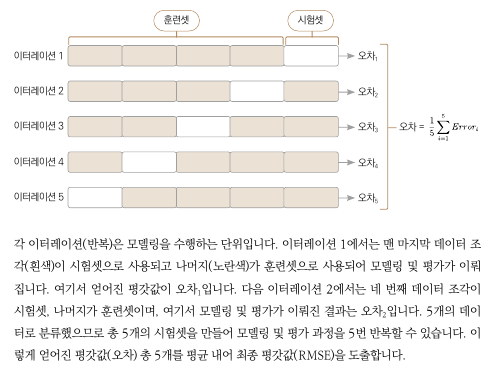

In [60]:
from sklearn.model_selection import KFold

 - KFold는 인덱스 값을 이용하여 데이터를 분할하는데, 중간에 빈값이 존재하면 에러 발생
  
  > 전처리에서 dropna()로 약 2%정도 제거하였음

  > 인덱스는 0-8127이지만 실제로는 7906줄 상태
  
 - reset_index() 사용하여 인덱스 정리

In [61]:
data

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,name_Ashok,name_Audi,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,0.318108,1248.0,74.00,190.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,370000,120000,0.287384,1498.0,103.52,250.00000,5.0,0,0,...,1,0,0,1,0,1,0,1,0,0
2,2006,158000,140000,0.220067,1497.0,78.00,124.54382,5.0,0,0,...,0,0,1,1,0,1,0,0,0,1
3,2010,225000,127000,0.312670,1396.0,90.00,219.66784,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,2007,130000,120000,0.200174,1298.0,88.20,112.77590,5.0,0,0,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,2013,320000,110000,0.230014,1197.0,82.85,113.70000,5.0,0,0,...,0,0,1,1,0,1,0,0,0,0
8124,2007,135000,119000,0.228385,1493.0,110.00,235.35840,5.0,0,0,...,1,0,0,1,0,1,1,0,0,0
8125,2009,382000,120000,0.262371,1248.0,73.90,190.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
8126,2013,290000,25000,0.320419,1396.0,70.00,140.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0


In [62]:
data.reset_index(drop=True, inplace=True) # drop매개변수 : 기존인덱스를 컬럼으로 가져오지 않음

In [63]:
data

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,name_Ashok,name_Audi,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,0.318108,1248.0,74.00,190.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,2014,370000,120000,0.287384,1498.0,103.52,250.00000,5.0,0,0,...,1,0,0,1,0,1,0,1,0,0
2,2006,158000,140000,0.220067,1497.0,78.00,124.54382,5.0,0,0,...,0,0,1,1,0,1,0,0,0,1
3,2010,225000,127000,0.312670,1396.0,90.00,219.66784,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,2007,130000,120000,0.200174,1298.0,88.20,112.77590,5.0,0,0,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7901,2013,320000,110000,0.230014,1197.0,82.85,113.70000,5.0,0,0,...,0,0,1,1,0,1,0,0,0,0
7902,2007,135000,119000,0.228385,1493.0,110.00,235.35840,5.0,0,0,...,1,0,0,1,0,1,1,0,0,0
7903,2009,382000,120000,0.262371,1248.0,73.90,190.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0
7904,2013,290000,25000,0.320419,1396.0,70.00,140.00000,5.0,0,0,...,1,0,0,1,0,1,0,0,0,0


In [64]:
kf = KFold(n_splits=5) # 5개의 데이터로 분할

In [65]:
X = data.drop('selling_price', axis=1)
y = data['selling_price']

In [66]:
# len(list(kf.split(X))) # 5 → 5번의 이터레이션을 의미(데이터도 5등분 됨)
# len(list(kf.split(X))[0]) # 2 → 첫번째 이터레이션에는 [[훈련셋][시험셋]]으로 나뉨
# len(list(kf.split(X))[0][0]) # 6324 → [훈련셋]
len(list(kf.split(X))[0][1]) # 1582 → [시험셋]

1582

In [67]:
# KFold 클래스의 함수인 split()으로 데이터 분할 → [train][train][train][train][test]
for i, j in kf.split(X): # 5번의 이터레이션을 돌면서 각 이터레이션 별 훈련셋, 시험셋 반환
    print(i, j)

[1582 1583 1584 ... 7903 7904 7905] [   0    1    2 ... 1579 1580 1581]
[   0    1    2 ... 7903 7904 7905] [1582 1583 1584 ... 3160 3161 3162]
[   0    1    2 ... 7903 7904 7905] [3163 3164 3165 ... 4741 4742 4743]
[   0    1    2 ... 7903 7904 7905] [4744 4745 4746 ... 6322 6323 6324]
[   0    1    2 ... 6322 6323 6324] [6325 6326 6327 ... 7903 7904 7905]


 - KFold를 통해 나오는 값들은 데이터들의 인덱스

  > X는 DataFrame 형식이므로 X[리스트] 하면 행이 아닌 열을 "우선" 기준으로 인덱싱 하게 됨, 행을 인덱싱 하려면, X[정수:정수] 방식으로 슬라이싱을 사용해야함, 슬라이싱을 사용하면, X[슬라이싱(행), 열], X[행, 슬라이싱(열)]

  > X.loc[리스트] : 행을 "우선" 기준으로 인덱싱

  > Y는 Series 형식이므로 Y[리스트]

In [68]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

 - 위와 같이 코드를 작성하면, 반복문이 순회할 때 마다 X_train, X_test, y_train, y_test값이 덧씌워짐

In [69]:
# 5번의 이터레이션으로 만들어지는 train_rmse와 test_rmse 값들을 리스트형태로 저장
train_rmse_total = [] 
test_rmse_total =[]

In [70]:
from tqdm import tqdm

for train_index, test_index in tqdm(kf.split(X), desc="이터레이션", mininterval=0.01):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 각 이터레이션 마다 모델생성 → 훈련 → 예측 → rmse계산 → rmse리스트에 저장
    model = RandomForestRegressor(random_state=100)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련데이터로 예측
    test_pred = model.predict(X_test)   # 시험데이터로 예측

    train_rmse = mean_squared_error(y_train, train_pred) ** 0.5 # 훈련데이터 예측값 rmse 계산
    test_rmse = mean_squared_error(y_test, test_pred) ** 0.5   # 시험데이터 예측값 rmse 계산

    train_rmse_total.append(train_rmse) # 리스트에 훈련데이터 예측값 rmse 추가
    test_rmse_total.append(test_rmse)   # 리스트에 시험데이터 예측값 rmse 추가

이터레이션: 5it [00:26,  5.21s/it]


In [71]:
train_rmse_total

[50825.5556350298,
 58854.04054344074,
 57904.19615940739,
 56218.23740006373,
 58967.150857632456]

 - 각 이터레이션 별 오차들 이므로 평균을 구해준다
 - 리스트에서는 mean() 함수가 없음

In [72]:
print('train_rmse :', sum(train_rmse_total)/len(train_rmse_total))

train_rmse : 56553.836119114814


In [73]:
print('test_rmse :', sum(test_rmse_total)/len(test_rmse_total))

test_rmse : 142936.58918244042


#### 이해하기 : 랜덤 포레스트
 - 결정 트리는 오버피팅 문제가 쉽게 발생
 - 랜덤 포레스트는 여러 트리를 활용하여 최종 모델 만듬

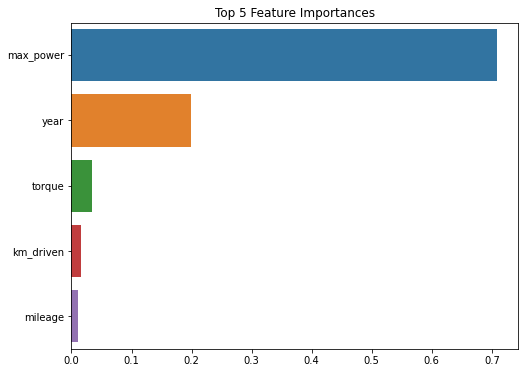

In [75]:
# 랜덤포레스트의 각 피처 중요도 시각화 : feature_importances_
ftr_importances_values = model.feature_importances_ # feature별 중요도(0~1)(array형식 )
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns) # Series형식, 인덱스와 크기 매칭
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5] # 내림차순 정렬

plt.figure(figsize=(8,6))
plt.title('Top 5 Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()